# Semantic Segment Road and Sidewalk
Tony Wang July 04 2023

After semantic segmentation of road and sidewalk, we obtain the pixel level binary mask of them. Which can be used to detect human-road relationship using rule-based comparision. Since the SAM didn't provide necessary api, I write some utility func to realize it

> This notebook is used for tutuorial demo, because I believe, compared to the unstable .py file, jupyter notebook would provide a vivid description and data pipeline demonstration.



## Library & Model Loading

In [23]:
import os
import cv2
# filter some annoying debug info
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import supervision as sv

import numpy as np
from PIL import Image
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor
#TODO name!
from groundingdino.util.inference import load_model, load_image, predict, annotate

# import SAM_utility # 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Paths to GroundingDINO and SAM checkpoints
GROUNDING_DINO_CONFIG_PATH = "../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "./weights/groundingdino_swint_ogc.pth"
MODEL_TYPE = "vit_b"
SAM_CHECKPOINT_PATH = "./weights/sam_vit_b_01ec64.pth"

# Predict classes and hyper-param for GroundingDINO
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25
PED_TRESHOLD = 0.5

NMS_THRESHOLD = 0.85
IOU_THRESHOLD = 0.5

In [2]:
# DEBUG = False
DEBUG = True


In [3]:
from DPT_module.dpt.models import DPTDepthModel
from DPT_module.dpt.midas_net import MidasNet_large
from DPT_module.dpt.transforms import Resize, NormalizeImage, PrepareForNet
import DPT_module.util.io as DPT_io
from torchvision.transforms import Compose

In [24]:
def predict_depth(image_path, output_path, model_path="DPT_module/weights/dpt_large-midas-2f21e586.pt", model_type="dpt_large", optimize=True):
    """
    Predict the depth map of a single image using DPT model.

    Args:
        img (ndarray): Input image.
        model_path (str): Path to the model weights.
        model_type (str): Type of the DPT model to use.

    Returns:
        prediction (ndarray): The predicted depth map.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if DEBUG:
        print("initialize")
        print("device: %s" % device)
    # load network
    if model_type == "dpt_large":
        model = DPTDepthModel(
            path=model_path,
            backbone="vitl16_384",
            non_negative=True,
            enable_attention_hooks=False,
        )
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    else:
        raise ValueError("Unsupported model type. Please use 'dpt_large'.")

    net_w = net_h = 384

    transform = Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method="minimal",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )

    model.eval()

    if optimize == True and device == torch.device("cuda"):
        model = model.to(memory_format=torch.channels_last)
        model = model.half()

    model.to(device)

    # transform input
    img = DPT_io.read_image(image_path)
    img_input = transform({"image": img})["image"]
    print("img.shape is",  img.shape)
    # compute depth map
    with torch.no_grad():
        sample = torch.from_numpy(img_input).to(device).unsqueeze(0)

        if optimize == True and device == torch.device("cuda"):
            sample = sample.to(memory_format=torch.channels_last)
            sample = sample.half()

        prediction = model.forward(sample)
        prediction = (
            torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            )
            .squeeze()
            .cpu()
            .numpy()
        )
    # DPT_io.write_depth(output_path, prediction, bits=2)

    print("finished")
    return prediction


prediction = 0

# prediction =  predict_depth("input/S0710/image_0006.png",output_path="DINOmasked/image_0006")
# obj_dict =  detect_road("input/S0710/.png",output_path="SSS.png" )# "DINOmasked/video_0060/image_0005.png")


In [5]:
import numpy as np
def get_distance_category(depth_map, person_mask):
    # Define depth categories
    categories = ['very close', 'close', 'medium', 'far', 'very far']


    # Find the lowest true point in mask A 
    y_coords, _ = np.nonzero(person_mask)
    lowest_point = int(np.max(y_coords) * 0.9 )#(huamn feet point)
    print(y_coords, lowest_point)
    mask_a_copy = person_mask.copy().astype(bool)
    # Slice mask A from the lowest point to the top
    mask_a_copy[:lowest_point, :] = False
    obj_depths = depth_map[mask_a_copy]
      # Handle case where no depth value is available
    if obj_depths.size == 0:
        return "unknown"
    feet_depth = np.median(obj_depths)


    # Compute depth range of the image
    min_depth, max_depth = np.min(depth_map), np.max(depth_map)

    # Compute boundaries for each category
    boundaries = np.linspace(min_depth, max_depth, len(categories) + 1)

    # Find which category the median depth of the object belongs to
    for i in range(len(boundaries) - 1):
        if boundaries[i] <= feet_depth < boundaries[i + 1]:
            return categories[i]

    return categories[-1]  # If for some reason it wasn't caught in the loop
obj_ms = np.array([ [1,1,1] ,[0,0,1],[1,0,0]   ]  )
print(obj_ms)
dep_ms = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(dep_ms)
get_distance_category(dep_ms,obj_ms)

[[1 1 1]
 [0 0 1]
 [1 0 0]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
[0 0 0 1 2] 1


'far'

The model loading is quite long
with some unremovable warning in gDINO, just ignore it

In [8]:
# Initialize GroundingDINO model
grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH, 
    device=DEVICE
)

# Initialize SAM model and predictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


# Data structure
LocationInfo: pack form to help data-alignment

In [9]:
class LocationInfo:
    def __init__(self, object_type, id, box, mask,confidence):
        self.object_type = object_type  # ('sidewalk', 'road', or 'person')
        self.id = id  # Unique ID within the type
        self.box = box  # Bounding box in xyxy format
        self.mask = mask  # Binary mask indicating the precise location of the object
        self.confidence = confidence #confidence of bbox
        self.distance = None # str,{very close,close, median, far, very far}
        self.angle = None    # horizontal angle relative to camera
    def get_area(self):
        """
        int: The area of the object in pixels.
        """
        return np.sum(self.mask)


## Utility Function

In [10]:

def show_mask(mask, ax, random_color=False):
    '''Display single mask to its image'''
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:] # more robust way of extracting the spatial dimensions of the array
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [11]:
def is_image_file(filename):
    IMAGE_EXT = ['.jpg', '.jpeg', '.png', '.bmp']
    return any(filename.endswith(extension) for extension in IMAGE_EXT)

def display_mask(SAM_masks,P_masks, P_boxes, DINO_boxes,  person_annotation,output_path):
    # Create a new subplot
    plt.figure(figsize=(16,9))
    # image = cv2.cvtColor( cv2.imread(image_path),cv2.COLOR_BGR2RGB )
    # Display the original image
    plt.axis('off')
 
    plt.imshow(person_annotation)
    i,j,k,d = 0,0,0,0
    for mask in SAM_masks:
        i += 1
        show_mask(mask, plt.gca(), random_color=True)
    for box in DINO_boxes:
        j += 1
        show_box(box, plt.gca())
    for mask in P_masks:
        k += 1
        show_mask(mask, plt.gca(), random_color=True)
    for box in P_boxes:
        d += 1
        show_box(box,plt.gca())
    if DEBUG:
        print("number of Surface mask, Road&sidewalk, People 's mask, actural people: ",i,j,k,d)

    plt.savefig(output_path)
    plt.close()
    return (i, j, k, d)


In [12]:
def nms_processing(detections ):
    """
    Non-Maximum Suppression (NMS) on detection results to eliminate overlapping bounding boxes.
    
    Args:
        detections (Detection): 
        - 'xyxy' (bounding box coordinates),
        - 'confidence' (confidence scores), 
        - 'class_id' (class IDs).
        
        nms_threshold (float): The threshold for the IOU (Intersection Over Union). Bounding boxes with IOU values greater than this 
        threshold will be suppressed.
    
    Returns:
        detections: The updated detections after performing NMS. 
    """
    nms_idx = torchvision.ops.nms(
        torch.from_numpy(detections.xyxy), 
        torch.from_numpy(detections.confidence), 
        NMS_THRESHOLD 
    ).numpy().tolist()

    detections.xyxy = detections.xyxy[nms_idx]
    detections.confidence = detections.confidence[nms_idx]
    detections.class_id = detections.class_id[nms_idx]
    return detections


## Architecture:
1. gDINO : grounding_dino_model.predict_with_classes

   CLASSES_prompt= ['road', 'sidewalk']

   Based on testing, this pair is most reliable (otherwise the sidewalk may messed up with road) 

   In this part, I use the box as Region of Interest(ROI) to further prompt SAM

2. Non-maximum suppression (NMS) :

   get rid of redundant and overlapping bounding boxes.

   the metric is Intersection over Union(IoU)

3. Prompting SAM with ROI, select mask with largest area, in this step, the road and sidewalk can be segmented with naming in pixel level accuracy.

4. save the result 

5. label the result with label and confidence

6. TODO: do image sequence experiment, analyze the behavior of person

7. TODO: split cases based on JAAD info

   - car is moving 
   - car is stopping
   - time
   - weather
   - more...

In GTX3090 environment, the algorithm runs relatively fast with GPU boosting.

(Not as bad as I guessed before, much faster than all of the online demo)


## Location utility function
- is_overlap: a mask-level comparitor func

In [13]:
def is_overlap(mask_a: np.ndarray, mask_b: np.ndarray):
    """
    Check if the bottom part of mask_a overlaps with mask_b.
    
    Args:
        mask_a: numpy array of shape (H, W). Binary mask of object A.
        mask_b: numpy array of shape (H, W). Binary mask of object B.

    Returns:
        bool. True if there is overlap, False otherwise.
    """
    
    # Check the inputs are binary masks
    assert mask_a.shape == mask_b.shape, "Both masks should have the same shape."
    assert np.logical_or(mask_a == 0, mask_a == 1).all(), "Mask A should be a binary mask."
    assert np.logical_or(mask_b == 0, mask_b == 1).all(), "Mask B should be a binary mask."

    # Find the lowest true point in mask A 
    y_coords, _ = np.nonzero(mask_a)
    lowest_point = int(np.max(y_coords) * 0.9 )#(huamn feet point)

    mask_a_copy = mask_a.copy()
    # Slice mask A from the lowest point to the top
    mask_a_copy[:lowest_point, :] = 0

    # Check for overlap
    overlap = np.logical_and(mask_a_copy, mask_b)

    return np.any(overlap), lowest_point


In [14]:
def compute_overlap(mask_a: np.ndarray, mask_b: np.ndarray):
    """
    Compute the percentage of mutual coverage between mask_a and mask_b.
    
    Args:
        mask_a: numpy array of shape (H, W). Binary mask of object A.
        mask_b: numpy array of shape (H, W). Binary mask of object B.

    Returns:
        float. The percentage of mutual coverage.
    """
    # Check the inputs are binary masks
    assert mask_a.shape == mask_b.shape, "Both masks should have the same shape."
    assert np.logical_or(mask_a == 0, mask_a == 1).all(), "Mask A should be a binary mask."
    assert np.logical_or(mask_b == 0, mask_b == 1).all(), "Mask B should be a binary mask."

    # Compute the intersection between the two masks
    intersection = np.logical_and(mask_a, mask_b)
    
    # Compute the union of the two masks
    union = np.logical_or(mask_a, mask_b)

    # Calculate the mutual coverage percentage
    overlap_percentage = np.sum(intersection) / np.sum(union)

    return overlap_percentage


Surface Utility Function

In [25]:
def get_location(bbox:np.ndarray, img_shape:np.ndarray):
    img_height, img_width = img_shape[:2]
    x_center = (bbox[0] + bbox[2]) / 2
    y_center = (bbox[1] + bbox[3]) / 2

    if x_center < img_width / 3:
        x_pos = "left"
    elif x_center < 2 * img_width / 3:
        x_pos = "middle"
    else:
        x_pos = "right"

    if y_center < img_height / 2:
        y_pos = "up"
    else:
        y_pos = "down"

    return f"{x_pos}_{y_pos}"

def get_surface_info(obj_dict:Counter , f):
    
    for key, obj_info in obj_dict.items():
        object_type = obj_info.object_type
        id = obj_info.id
        bbox = obj_info.box
        h, w = obj_info.mask.shape[-2:]
        location = get_location(bbox, (h, w)) 
        if DEBUG:
            print(f"{object_type} {id} is at {location}")
        f.write(f"{object_type} {id} is at {location}\n")
        if obj_info.object_type == "person":
            f.write(f"The [distance,angle] from {object_type} {id} to our dashcam is: [{obj_info.distance},{obj_info.angle}]\n")
            if DEBUG:
                print(f"The [distance,angle] from {object_type} {id} to our dashcam is: [{obj_info.distance},{obj_info.angle}]\n")


In [ ]:

# Get the estimated angle of each person to the dashcam
def estimate_angle(image, person:LocationInfo, fov_horizontal = 170):
    
    # Step 1: Filter out detections that are not pedestrians
    if person.object_type!= 'person':
        return None
    
    # Step 2: Estimate distance
    box = person.box
    bottom_center = (box[0]+box[2])/2, box[3] # feet 
    distance = person.distance
    # Step 3: Estimate angle
    image_center_y = image.shape[1] / 2
    pedestrian_center = bottom_center[0]
    relative_position = pedestrian_center - image_center_y
    # Why?
    angle = np.arctan(relative_position / distance * np.tan(fov_horizontal / 2))
    
    return np.degrees(angle)

def describe_angle(angle):
    """Describe the angle in simple terms."""
    if angle == None:
        return "unknown"
    # Handle the straight-ahead case
    if -10 <= angle <= 10:
        return "straight ahead"

    # Handle the right side
    if 10 < angle <= 45:
        return "slightly to the right"
    elif 45 < angle <= 135:
        return "to the right"
    elif angle > 135:
        return "far to the right"

    # Handle the left side
    if -45 >= angle > -10:
        return "slightly to the left"
    elif -135 >= angle > -45:
        return "to the left"
    elif angle < -135:
        return "far to the left"


In [27]:
def obj_print(obj_dict):
    for name, person in obj_dict.items():
        print(name)
        print(person.object_type)
        print(person.box)
        print(person.distance)
        print(person.angle)



In [17]:
def write_to_txt(image_path, output_path, p_surface_overlaps, counts, labels, p_labels,obj_dict):
    '''
    str image_path: the relative path to input image
    str output_path: "DINOmasked/video_0018/man.png"
    
    
    '''
    output_dir = Path(output_path).parent
    img_name = image_path[-8:-4]
    txt_name = "Info_Video_"+ str(output_dir)[-4:] +".txt"
    txt_path = os.path.join(output_dir, txt_name) 

    if DEBUG:
        print("output_dir: ", output_dir)
        print("image_name: ", img_name)
        print("txt_path: ", txt_path)
    # Check if file already exists
    if DEBUG:
        if os.path.exists(txt_path):
            # Read in existing data
            with open(txt_path, 'r') as f:
                existing_data = f.read()

            # If the info of the current image has already been recorded, return without appending
            if f"INFO of {img_name}:\n" in existing_data:
                print(f"ERROR: the info of{img_name} has been generated")
                return
    with open(txt_path, 'a') as f: # 'a' option is for appending to the file if it exists
        f.write(f"INFO of {img_name}:\n")

        get_surface_info(obj_dict,f)
        
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                f.write(f"Person {person.id} is on the {surface_str}\n")
            else:
                f.write(f"Person {person.id} is not on any detected surface\n")
                
        f.write(f"number of Surface mask, Road&sidewalk, People 's mask, actural people: {counts}\n")
        f.write(f"Labels: [{', '.join(labels)}]\n")
        f.write(f"Person Labels: [{', '.join(p_labels)}]\n\n")





## Key Function

In [18]:
# Prompting SAM with Region of Interest
def segment_ROI(sam_predictor: SamPredictor, image: np.ndarray, boxes: np.ndarray):

    sam_predictor.set_image(image)
    result_masks = []
    for box in boxes:
        masks_np, iou_predictions, _ = sam_predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box,
        multimask_output=True,
        )
        #TODO Remove the following line to get all the person masks
        # index = np.argmax(scores_np) 
        # Add all masks to the result, not just the one with the highest score
        # Filter out masks with IoU scores below the threshold
        for mask, score in zip(masks_np, iou_predictions):
            if score >= IOU_THRESHOLD:
                result_masks.append(mask)

    return np.array(result_masks)



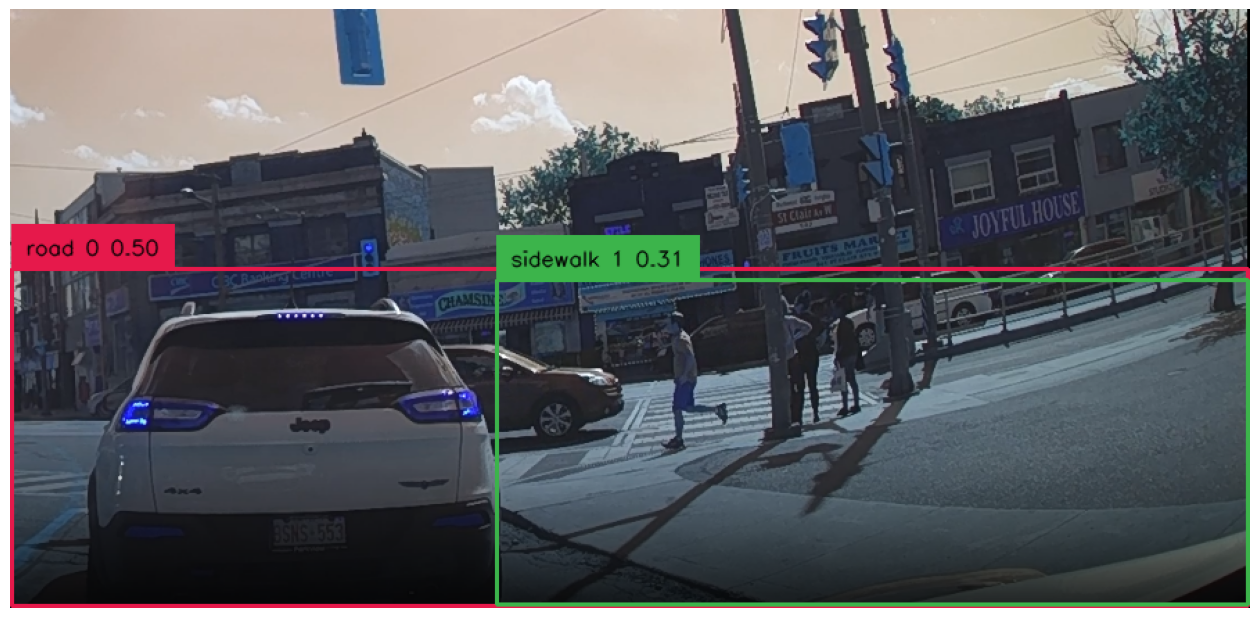

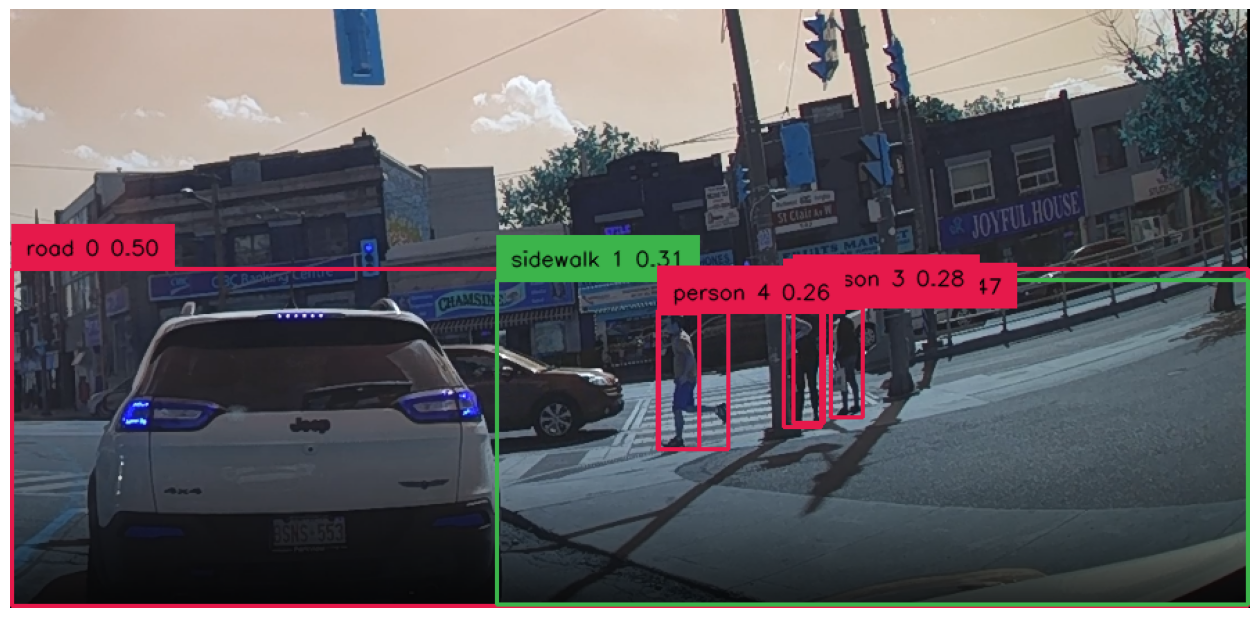

initialize
device: cuda
img.shape is (432, 895, 3)
finished
[197 198 199 ... 430 430 430] 387
[203 203 203 ... 430 430 430] 387
[197 205 215 ... 428 428 428] 385
[202 202 202 ... 430 430 430] 387
[202 202 202 ... 429 430 430] 387
Person 0 is on the road 0, sidewalk 1
Person 1 is on the road 0, sidewalk 1
Person 2 is on the road 0, sidewalk 1
Person 3 is on the road 0, sidewalk 1
Person 4 is on the road 0, sidewalk 1
number of Surface mask, Road&sidewalk, People 's mask, actural people:  6 2 6 5
output_dir:  DINO_masked
image_name:  ne_2
txt_path:  DINO_masked/Info_Video_sked.txt
road 0 is at middle_down
sidewalk 1 is at right_down
person 0 is at middle_down
The [distance,angle] from person 0 to our dashcam is: [very far,None]

person 1 is at right_down
The [distance,angle] from person 1 to our dashcam is: [far,None]

person 2 is at middle_down
The [distance,angle] from person 2 to our dashcam is: [very far,None]

person 3 is at middle_down
The [distance,angle] from person 3 to our dash

In [30]:

def detect_road(image_path,output_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image at path {image_path} could not be loaded. Skipping.")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    except Exception as e:
        print(f"Failed to process image at {image_path}. Error: {e}")
        return None
    
    ROAD_SIDEWALK = ['road', 'sidewalk'] 
    P_CLASS     = ['person'] #,'bike']
    # the person label lower gDINO's performance
    # so I split them

    # detect road and sidewalk
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes = ROAD_SIDEWALK,
        box_threshold= BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = nms_processing(detections)
    # detect person 
    p_detections = grounding_dino_model.predict_with_classes(
        image = image,
        classes = P_CLASS , 
        box_threshold= BOX_TRESHOLD,
        text_threshold=PED_TRESHOLD - 0.3
    )
    p_detections = nms_processing(p_detections)

    box_annotator = sv.BoxAnnotator()
    person_annotator = sv.BoxAnnotator()

    labels = [
        f"{ROAD_SIDEWALK[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(detections)]

    P_labels = [
        f"{P_CLASS[class_id]} {i} {confidence:0.2f}" 
        for i, (_, _, confidence, class_id, _) in enumerate(p_detections)]

    DINO_boxes = np.array(detections.xyxy)
    P_boxes    = np.array(p_detections.xyxy)
    
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections ,labels=labels)
    if DEBUG:
        sv.plot_image(annotated_frame, (16, 16))
    person_annotation = person_annotator.annotate(scene=annotated_frame,detections= p_detections,labels= P_labels)
    if DEBUG:
        sv.plot_image(person_annotation, (16, 16))
    # cv2.imwrite("annotated_image.jpg", annotated_frame)
    
    SAM_masks = segment_ROI(sam_predictor,image,DINO_boxes)
    P_masks = segment_ROI(sam_predictor,image,DINO_boxes)

    # Create a list of LocationInfo objects for each detected object
    obj_dict = Counter()
    
    for i, (box, label, mask) in enumerate(zip(DINO_boxes, labels, SAM_masks)):
        object_type, id, confidence   = label.split(' ')
        index = object_type +id
        obj_dict[index] =  (LocationInfo(object_type, int(id), box, mask,confidence)) 

    for i, (box, label, mask) in enumerate(zip(P_boxes, P_labels, P_masks)):
        object_type, id, confidence = label.split(' ')
        index = object_type+id
        obj_dict[index] = (LocationInfo(object_type, int(id), box, mask,confidence)) 

    depth_map = predict_depth(image_path,output_path)
    
    # Analyze where each person is standing
    p_surface_overlaps = []
    
    for name, person in obj_dict.items():
        if person.object_type != "person":
            continue # We only want to analyze persons
        person.distance = get_distance_category(depth_map,person.mask)
        # person.angle   = estimate_angle(image,person)
        
        overlaps = []
        for name, surface in obj_dict.items():
            # We only want to analyze surfaces (road or sidewalk)
            if surface.object_type not in ROAD_SIDEWALK: 
                continue

            # Check if the person and the surface overlap
            overlap, _ = is_overlap(person.mask, surface.mask)
            if overlap:
                overlaps.append(surface)

        p_surface_overlaps.append((person, overlaps))


    if DEBUG:
        # Print out the analysis results
        for person, surfaces in p_surface_overlaps:
            if surfaces:
                surface_str = ', '.join([f"{surface.object_type} {surface.id}" for surface in surfaces])
                print(f"Person {person.id} is on the {surface_str}")
            else:
                print(f"Person {person.id} is not on any detected surface")

    (i, j, k, d) = display_mask(SAM_masks,P_masks,P_boxes,DINO_boxes,person_annotation,output_path)
    

    write_to_txt(image_path, output_path, p_surface_overlaps, (i, j, k, d), labels, P_labels,obj_dict)

    plt.close()
    
    # return DINO_boxes,labels,P_labels,SAM_masks,P_masks
    return obj_dict

obj_dict = detect_road("input/scene_2.png",output_path="DINO_masked/scene_2.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("input/video_0031/image_0005.png",output_path="DINOmasked/man.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("JAAD_seg_by_sec/video_0268/image_0001.png",output_path="DINOmasked/video_0268/image_0001.png")
# DINO_boxes,labels,P_labels,SAM_masks,P_masks = detect_road("JAAD_seg_by_sec/video_0268/image_0003.png",output_path="DINOmasked/video_0268/image_0003.png")
# obj_dict,labels,p_labels =  detect_road("JAAD_seg_by_sec/video_0060/image_0005.png",output_path="SSS.png" )# "DINOmasked/video_0060/image_0005.png")
# obj_dict =  detect_road("input/S0710/image_0005.png",output_path="SSS.png" )# "DINOmasked/video_0060/image_0005.png")

obj_print(obj_dict)


## File IO logic
the following code demonstrate how is the IO logic organized

For the sake of fast file inquiry, I used library: Path() and os

Feel free to modify this part if you need, just in case the content is too big, which may crash the kernel

In [ ]:
image_path = "input/video_0268/image_0001.png"
output_path = "DINOmasked/video_0018/man.png"

output_dir = Path(output_path).parent

print(output_dir)
img_name = image_path[-8:-4]
txt_name = "Info_Video_"+ str(output_dir)[-4:] +".txt"
txt_path = os.path.join(output_dir, txt_name) 
print(txt_path)



DINOmasked/video_0018
DINOmasked/video_0018/Info_Video_0018.txt


In [ ]:
STOP RUNNING THE MAIN PROGRAM

SyntaxError: invalid syntax (418665172.py, line 1)

## Main Function

In [ ]:
input_dir = Path("JAAD_seg_by_sec") # contain many folders  JAAD_seg_by_sec
output_dir = Path('DINOmasked')
output_dir.mkdir(parents=True, exist_ok=True)

print("===== Start =====")
i = 1
# Use rglob to recursively find all image files
for image_path in input_dir.rglob('*'):
    if is_image_file(str(image_path)):
        relative_path = image_path.relative_to(input_dir)

        output_path = output_dir / relative_path
        output_path.parent.mkdir(parents=True,exist_ok=True)

        if output_path.exists():
            print(f"Already scanned {output_path}, next one")
            continue
        else:
            print("Processing: ", i)
            i += 1
            print(f"Image path: {os.path.basename(str(image_path))}")

            result = detect_road(str(image_path),str(output_path))

            if result is not None:
                print(f"Detected: {image_path}") 
            else: 
                print( "failed to detect result")

print("===== END =====")
                


===== Start =====
Already scanned DINOmasked/video_0286/image_0001.png, next one
Already scanned DINOmasked/video_0286/image_0002.png, next one
Already scanned DINOmasked/video_0286/image_0003.png, next one
Already scanned DINOmasked/video_0286/image_0004.png, next one
Already scanned DINOmasked/video_0286/image_0005.png, next one
Already scanned DINOmasked/video_0286/image_0006.png, next one
Already scanned DINOmasked/video_0286/image_0007.png, next one
Already scanned DINOmasked/video_0286/image_0008.png, next one
Already scanned DINOmasked/video_0286/image_0009.png, next one
Already scanned DINOmasked/video_0006/image_0001.png, next one
Already scanned DINOmasked/video_0006/image_0002.png, next one
Already scanned DINOmasked/video_0006/image_0003.png, next one
Already scanned DINOmasked/video_0006/image_0004.png, next one
Already scanned DINOmasked/video_0006/image_0005.png, next one
Already scanned DINOmasked/video_0006/image_0006.png, next one
Already scanned DINOmasked/video_0006

: 

: 

In [ ]:
input_dir  = Path("input")
i = 0
for image_path in input_dir.rglob('*'):
    if i > 30: break
    
    if is_image_file(str(image_path)):
        i += 1

        print("image path is" ,image_path)
        relative_path = image_path.relative_to(input_dir)

        output_filename = 'D_' + relative_path.name
        
        output_path = Path(os.path.join( output_dir , output_filename))
        print("output_path path is" ,output_path)
        output_path.parent.mkdir(parents=True,exist_ok=True)


image path is input/man.png
output_path path is DINOmasked/D_man.png
image path is input/man_black.png
output_path path is DINOmasked/D_man_black.png
image path is input/scene_2.png
output_path path is DINOmasked/D_scene_2.png
image path is input/scene_2_black.png
output_path path is DINOmasked/D_scene_2_black.png
image path is input/video_0018/image_0001.png
output_path path is DINOmasked/D_image_0001.png
image path is input/video_0018/image_0002.png
output_path path is DINOmasked/D_image_0002.png
image path is input/video_0018/image_0003.png
output_path path is DINOmasked/D_image_0003.png
image path is input/video_0018/image_0004.png
output_path path is DINOmasked/D_image_0004.png
image path is input/video_0018/image_0005.png
output_path path is DINOmasked/D_image_0005.png
image path is input/video_0018/image_0006.png
output_path path is DINOmasked/D_image_0006.png
image path is input/video_0018/image_0007.png
output_path path is DINOmasked/D_image_0007.png
image path is input/video_